# Exam Approval Prediction
In this challenge, you will tackle the task of predicting the probability that a student will pass a
grade. As a data scientist, you will have to choose and apply the best algorithm to build a predictive
model.
Imagine you are part of a data science team working for an educational institution. The team is
tasked with developing a predictive model that can assist in identifying students who are likely to pass or
fail the grade. Such a model can provide valuable insights into student performance and help in designing
targeted interventions to support struggling students.

In [1]:
# Importing libraries as a whole
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
SEED = 42

# Loading Data

## Feature Descriptions

In [3]:
!more student.txt

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "

In [79]:
# Using os module to build OS-agnostic file paths
math_file = os.path.join('.', 'student-mat.csv')
port_file = os.path.join('.', 'student-por.csv')

In [5]:
math_df = pd.read_csv(math_file, sep=';')
port_df = pd.read_csv(port_file, sep=';')

In [6]:
math_df.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10


## Missing Values

In [7]:
def show_invalid_values_info(df, small_pct_limit=0.15, mod_pct_limit=0.3):
    tmp_df = pd.DataFrame()
    tmp_df['No. of valid values'] = df.count().values
    tmp_df['No. of invalid values'] = df.isnull().sum().values
    tmp_df.set_index(df.columns, inplace=True)
    return tmp_df

In [8]:
show_invalid_values_info(math_df)

,No. of valid values,No. of invalid values
school,395,0
sex,395,0
age,395,0
address,395,0
famsize,395,0
Pstatus,395,0
Medu,395,0
Fedu,395,0
Mjob,395,0
Fjob,395,0


In [9]:
show_invalid_values_info(port_df)

,No. of valid values,No. of invalid values
school,649,0
sex,649,0
age,649,0
address,649,0
famsize,649,0
Pstatus,649,0
Medu,649,0
Fedu,649,0
Mjob,649,0
Fjob,649,0


There seem to be no missing values in both datasets. 395 students are taking math classes, while 649 are taking portuguese classes. Also, it is stated in the original repository of the datatset that 382 of those students are taking both classes at the same time.

## Observations about Modelling

The goal of this project is to build a predictive model that can assist in identifyng studets who are likely to pass or fail the grade and provide valuable insight into student performance in order to support struggling students.   
Having two datasets, one for Portuguese and one for Mathematics, it is advisable to build two different models to identify struggling students (because getting a high grade in a specific course could be influenced by different predictors). **Due to time limitations, we choose to predict the approval rate only in the Mathematics class**, for the following reasons:
* Mathematics is one of the hardest subjects for students in school. Helping them achieve higher grades into this area may result into a better overall academic performance.
* It is likely that the predictors for classifying students in this field are common to other fields of knowledge as well.
* The vast majority of people in the Mathematics class (395 students) is also taking Portugese classes (382 students in both classes), so modelling student perfomance in the first field may give some insight into how the same students could perform in Portugese.

# Exploratory Data Analysis
We'll take a look at the value sin the dataset and identify potential predictors for our future model

Several features CANNOT be used for modelling student performance for several reasons:
* They are not avaliable before starting a new course:
    * "absences", "G1"/"G2": Number of absenses and grades are not known before starting classes.
* They could not be retrieved in a reliable way:
    * "romantic","Walc"/"Dalc": Teenage students are not likely to provide reliable information about their romantic relationships or the amount of alcohol they consume.

## Numerical Columns
In this area we realize univariate and bivariate analysis of numerical features using histograms and correlation matrices.
Some features have been previouly "binned" into unbalanced categories (such as "studytime" or "traveltime") while others are ordinal features (such as "famrel"), but treating them as numerical features can beneficial for identifying patterns in the EDA process (for example: the higher the score of the "studytime" or "famrel" features, the higher the final grade of the student)

### Histograms

In [10]:
num_cols = ['age', 'health', 'traveltime',
           'failures', 'studytime', 'absences',
           'famrel', 'Medu', 'Fedu',
           'freetime', 'goout', 'Dalc', 'Walc',
           'G3']

In [11]:
def hists(df, field_names, title='Histograms for numerical variables', bins=25, max_cols=4, max_fig_width=8):
    # Calc. number of plots
    number_of_plots = len(field_names)
    # Calc. number of cols
    if number_of_plots < max_cols: no_cols = number_of_plots
    else: no_cols = max_cols
    # Calc. number of rows
    if number_of_plots <= no_cols: no_rows = 1
    elif number_of_plots % no_cols == 0: no_rows = number_of_plots // max_cols
    else: no_rows = (number_of_plots // max_cols) + 1
    # Calc. figure dimensions
    plot_height = max_fig_width // no_cols
    if plot_height <= 1: plot_height == 2
    fig_height = plot_height * no_rows + 1
    # Plotting
    df.hist(field_names, bins=bins, layout=(no_rows, no_cols), figsize=(max_fig_width, fig_height))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

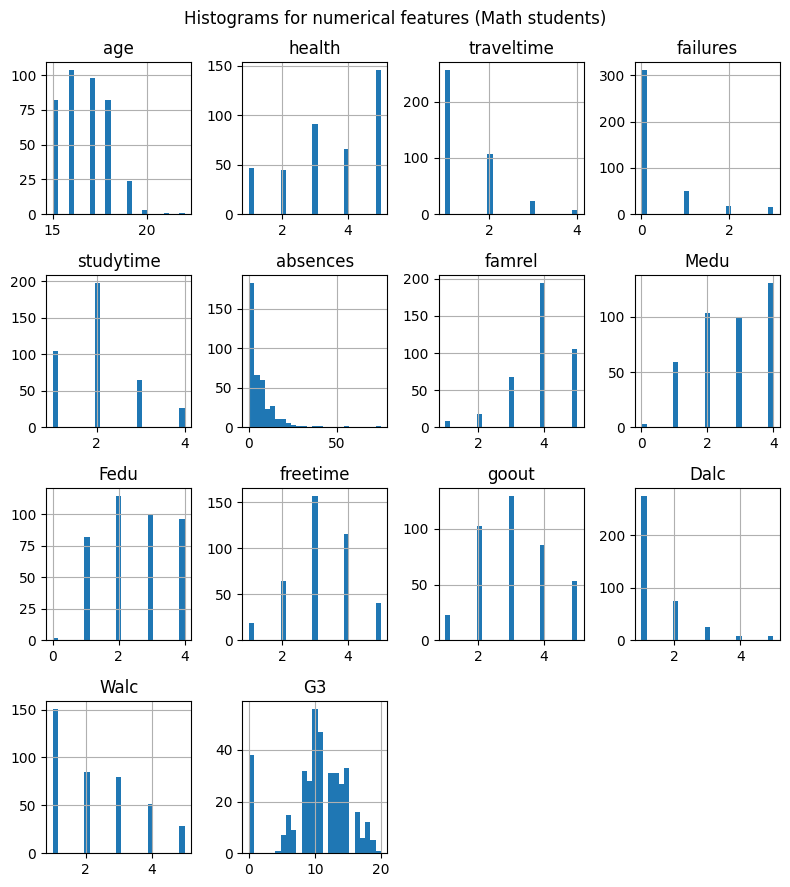

In [12]:
hists(math_df, num_cols, title='Histograms for numerical features (Math students)')

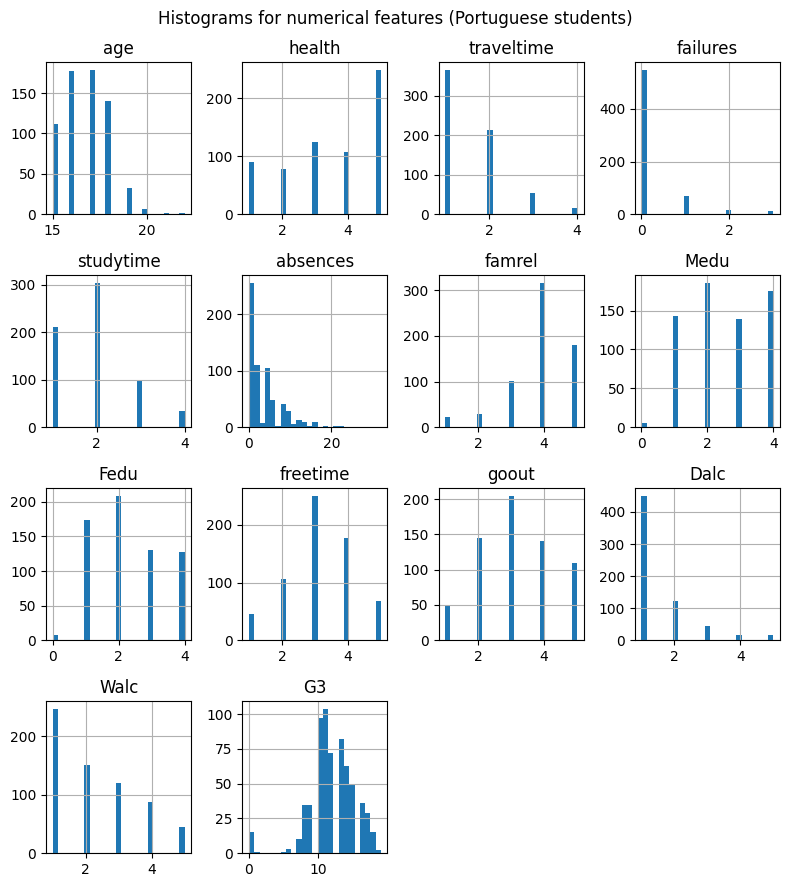

In [13]:
hists(port_df, num_cols, title='Histograms for numerical features (Portuguese students)')

Portugese students seems to have a higher approval rate, due to Portuguese's G3 distribution having a mean around the requiered aproval grade (12), while Mathematics grades are centered around 10. This proves the hypothesis where it is stated that **Mathematics is a harder subject for students**. Also, **there's a number of anomalous students that have a final grade of 0 in Mathematics**. They could represent a particularly interesing susbset of students that require academic help.

### Correlation Matrices
Correlation scores higher than 0.3 or lower than -0.3 are represented as color-filled squares in the following correlation matrices. Scores between -0.3 and 0.3 are considered to be weak correlations and thus not highlighted.

In [14]:
def plot_corr_matrix(df, min_corr_threshold = 0.3, title=''):
    corr_mx_df = df.corr()
    corr_mx_with_colors = corr_mx_df.map(lambda val: val if abs(val) >= min_corr_threshold else 0.0)
    sns.heatmap(corr_mx_with_colors, cmap ='RdYlGn', vmin=-1.0, vmax=1.0, xticklabels=True, yticklabels=True, linewidths = 0.2)
    plt.title(title)
    plt.show()

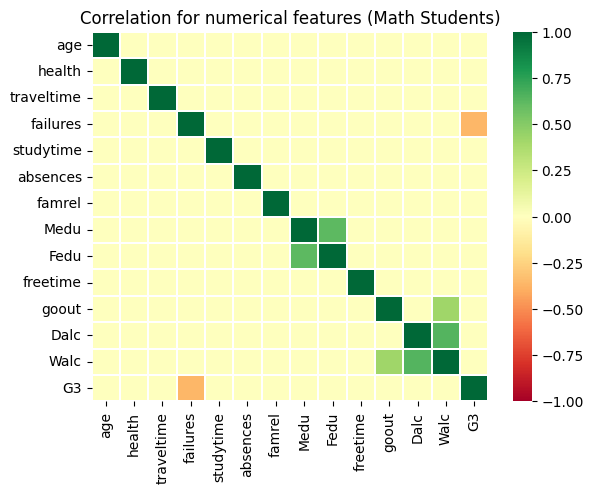

In [15]:
plot_corr_matrix(math_df[num_cols], title='Correlation for numerical features (Math Students)')

**Only the "failures" seem to have a relevant linear relationship with the target variable.** This does not mean it it the only important one, becasuse there could be polynomial relationships between other features.

### Scatter Plots
Visualizing some specific relatioships maybe beneficial to assesing the importance of other features, such as "studytime" and "famrel".

<Axes: title={'center': 'Relationship between no. of hours studying and final grades of students'}, xlabel='studytime', ylabel='G3'>

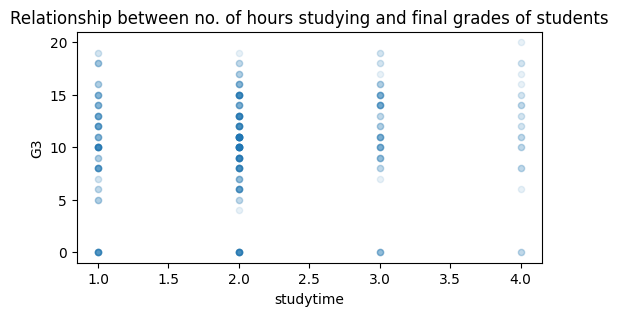

In [16]:
math_df.plot.scatter('studytime', 'G3', alpha=0.1, figsize=(6, 3),
                    title='Relationship between no. of hours studying and final grades of students')

<Axes: title={'center': 'Relationship between quality of family relationships and final grades of students'}, xlabel='famrel', ylabel='G3'>

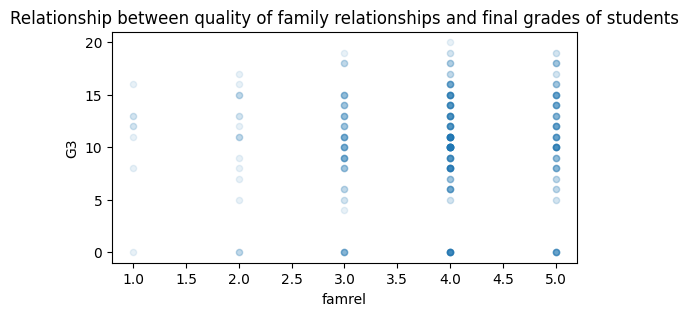

In [17]:
math_df.plot.scatter('famrel', 'G3', alpha=0.1, figsize=(6, 3),
                    title='Relationship between quality of family relationships and final grades of students')

There seems to be a slight correlation between the amount of time a teenager dedicates to studying in a week and his/her final grades. For this reason. **we'll consider "studytime" as a promising predictor in the modelling phase**. Meanwhile, quality of family relationships see to have no relevant value for the model.

## Categorical Variables
Here we visualize the importance of certain demographic categories in the performance of students. The boxplots are used to represent the distribution of grades between each class of every categorical feature in the dataset. Those boxplot that exhibit a very different distribution (for example, having very different means or variances) could be good predictors for the modelling phase.

In [18]:
def boxplot_cat_to_num(df, cat_field, num_field, title, size=(10, 3)):
    # Preparations
    x_data = df[cat_field] if type(cat_field)=='string' else cat_field
    y_data = df[num_field] if type(num_field)=='string' else num_field
    # Plotting
    plt.figure(figsize=size)
    fig = sns.boxplot(x=x_data, y=y_data, data=df)
    _, labels = plt.xticks()
    _ = fig.set_xticklabels(labels, rotation=90)
    plt.title(title)
    plt.show()

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


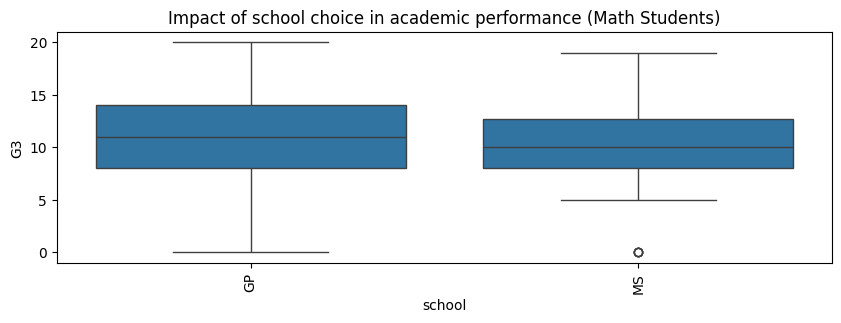

In [19]:
boxplot_cat_to_num(math_df, 'school', 'G3', 'Impact of school choice in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


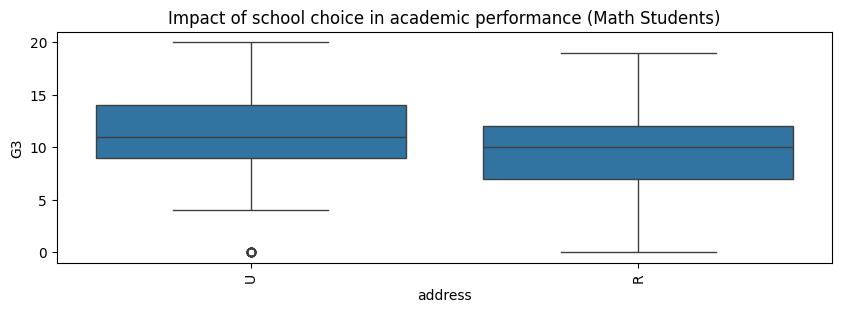

In [20]:
boxplot_cat_to_num(math_df, 'address', 'G3', 'Impact of school choice in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


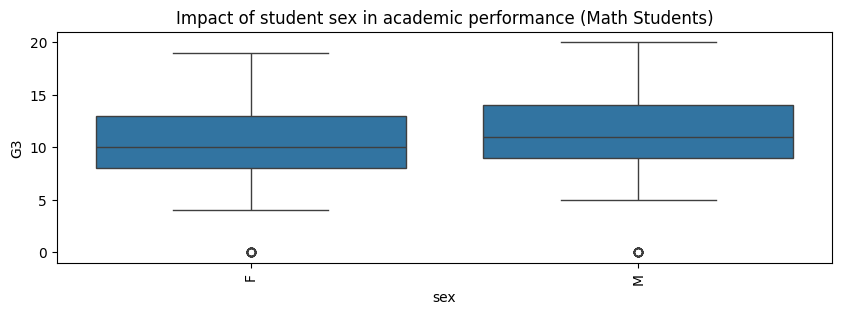

In [21]:
boxplot_cat_to_num(math_df, 'sex', 'G3', 'Impact of student sex in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


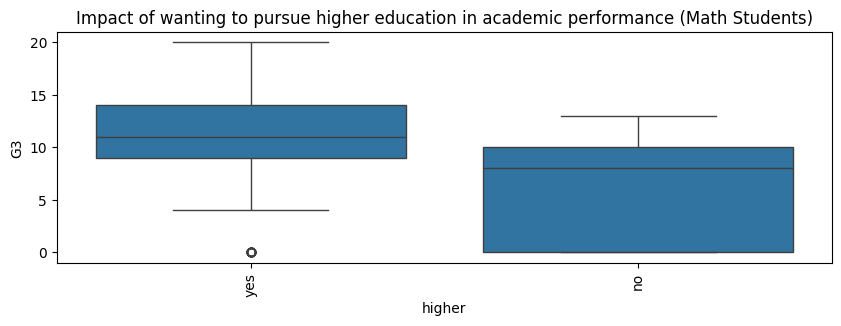

In [22]:
boxplot_cat_to_num(math_df, 'higher', 'G3', 'Impact of wanting to pursue higher education in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


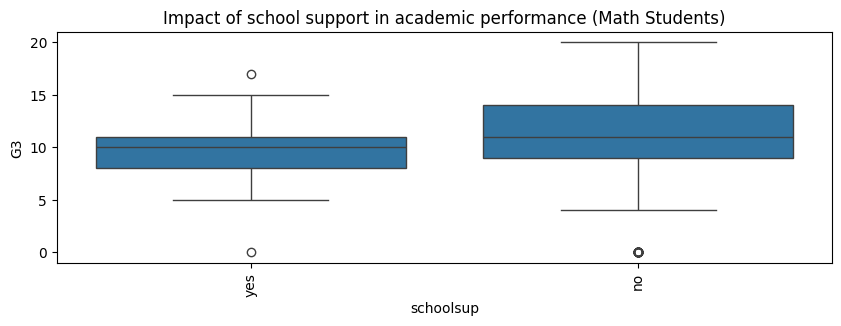

In [23]:
boxplot_cat_to_num(math_df, 'schoolsup', 'G3', 'Impact of school support in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


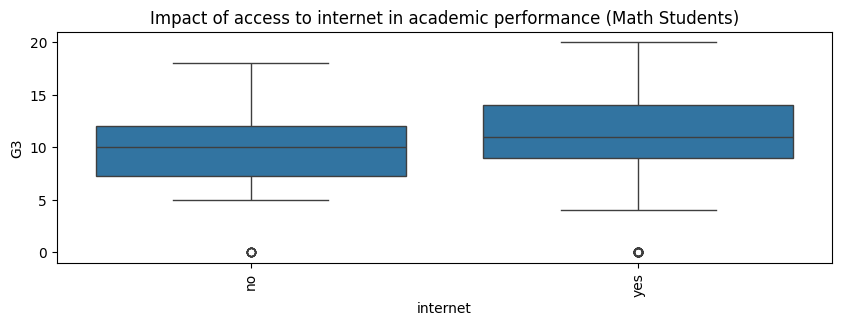

In [24]:
boxplot_cat_to_num(math_df, 'internet', 'G3', 'Impact of access to internet in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


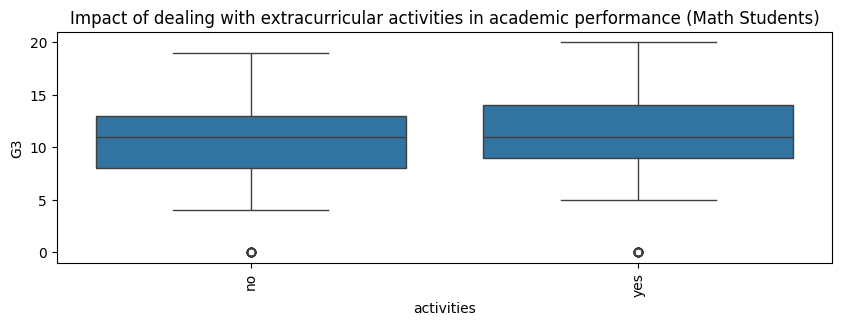

In [25]:
boxplot_cat_to_num(math_df, 'activities', 'G3', 'Impact of dealing with extracurricular activities in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


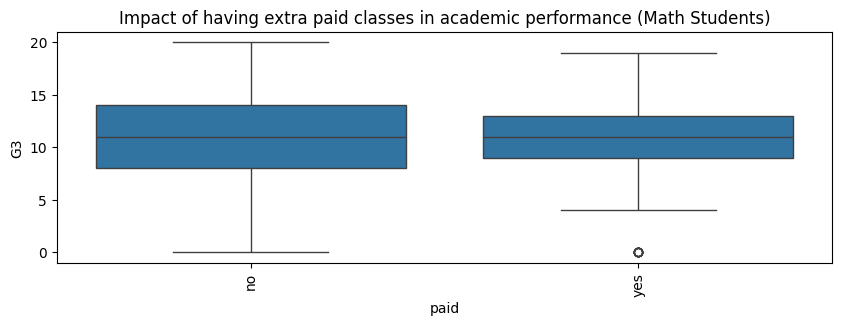

In [26]:
boxplot_cat_to_num(math_df, 'paid', 'G3', 'Impact of having extra paid classes in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


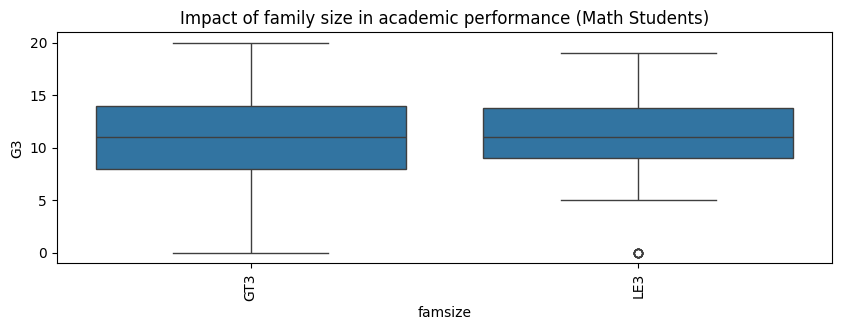

In [27]:
boxplot_cat_to_num(math_df, 'famsize', 'G3', 'Impact of family size in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


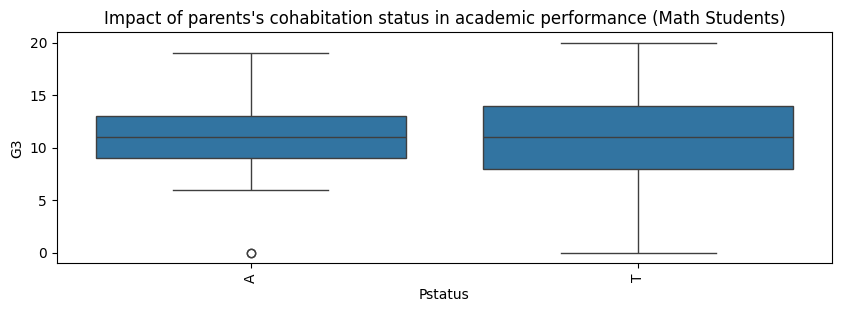

In [28]:
boxplot_cat_to_num(math_df, 'Pstatus', 'G3', 'Impact of parents\'s cohabitation status in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


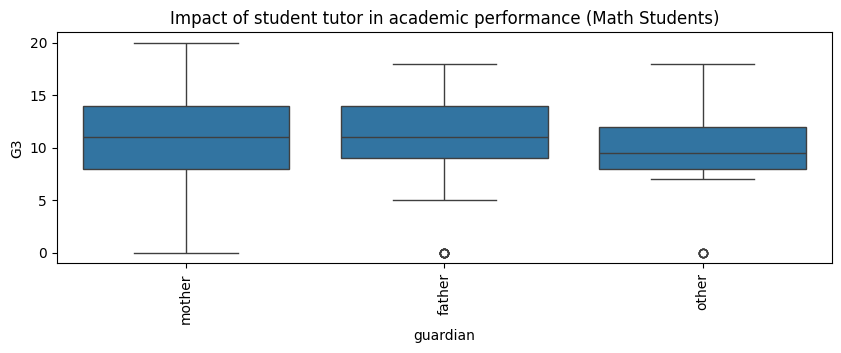

In [29]:
boxplot_cat_to_num(math_df, 'guardian', 'G3', 'Impact of student tutor in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


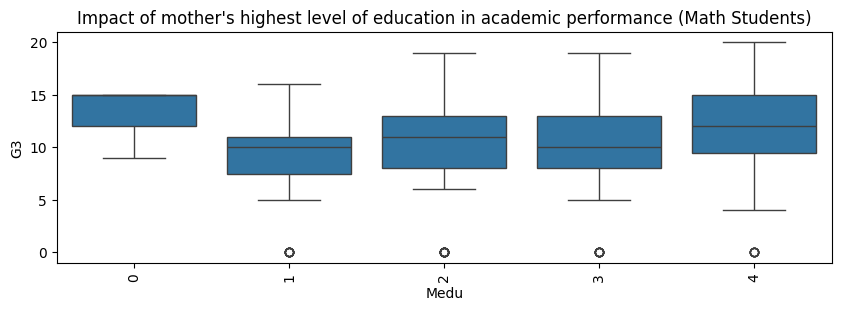

In [30]:
boxplot_cat_to_num(math_df, 'Medu', 'G3', 'Impact of mother\'s highest level of education in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


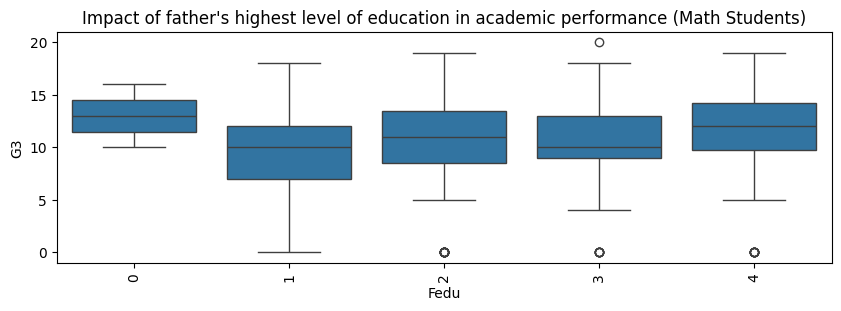

In [31]:
boxplot_cat_to_num(math_df, 'Fedu', 'G3', 'Impact of father\'s highest level of education in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


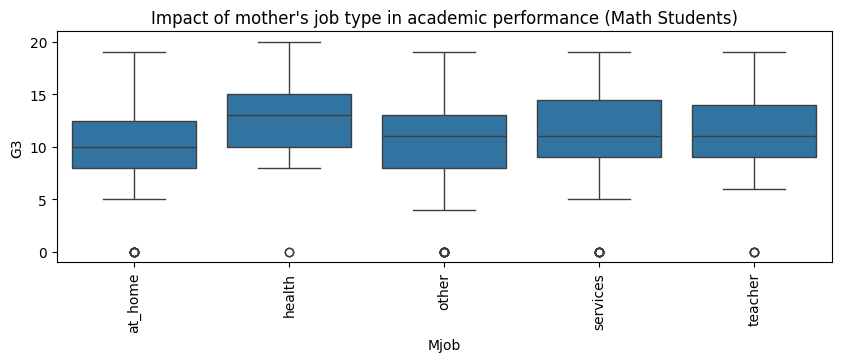

In [32]:
boxplot_cat_to_num(math_df, 'Mjob', 'G3', 'Impact of mother\'s job type in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


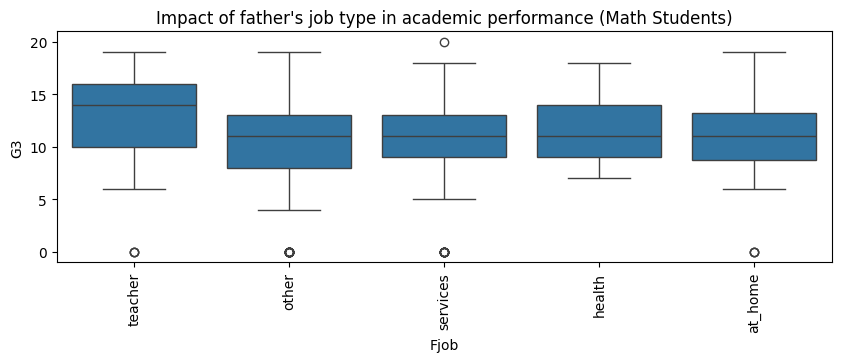

In [33]:
boxplot_cat_to_num(math_df, 'Fjob', 'G3', 'Impact of father\'s job type in academic performance (Math Students)')

C:\Users\Esteban Brito\AppData\Local\Temp\ipykernel_4956\1122348261.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = fig.set_xticklabels(labels, rotation=90)


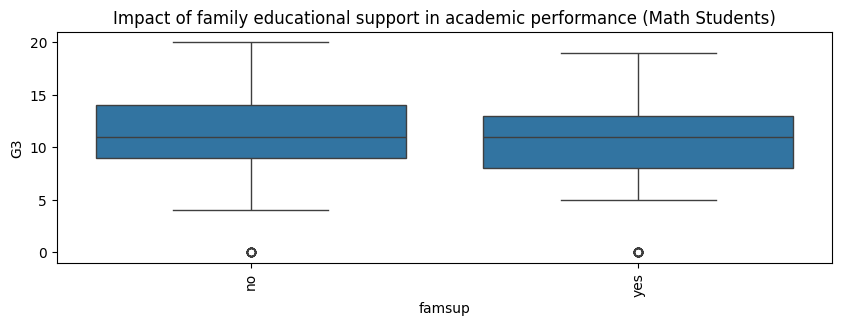

In [34]:
boxplot_cat_to_num(math_df, 'famsup', 'G3', 'Impact of family educational support in academic performance (Math Students)')

It seems that **the highest predictor for achieving a higher grade in Mathematics is the desire for a higher education**. That could motivate them to excel at their classes.
Also, **having a father/mother working as a teacher also helps**. It is not shown that the parent's cohabitation status by itself is relevant to student performance, but **we can assumme that the "Pstatus" field is also important** when used in tandem with other features ("Mjob"/"Fjob").

Other characteristics that define a student with a low performance are:
* Having **no access to internet**.
* **Being tutored by someone other than their mother/father**.
* **Not living in a urban area**.

## Feature Selection and Engineering
Here we select and combine our features to provide a better minable version of the dataset. We include the following information of students:

* failures: The number of past class failures.
* studytime: The time they dedicate to studying (represented as a numerical variable due to its ordinal nature).
* higher: The desire for a higher education (repr. as 0 = No / 1 = Yes).
* internet: Having access to internet at home (repr. as 0 = No / 1 = Yes).
* urban: Living in a urban area (repr. as 0 = No, 1 = Yes).
* teacher: Having at least one parent working as a teacher (repr. as 0 = No / 1 = Yes).
* Pstatus: Cohabitating with their parents (repr. as 0 = No / 1 = Yes).
* parents: Being tutored by their parents and not other people (repr. as 0 = No / 1 = Yes)
* grade: Having a high grade (1 if G3 >= 12 else 0)

In [35]:
# Selected dataset
sel_df = pd.DataFrame()

In [36]:
sel_df['failures'] = math_df['failures']

In [37]:
sel_df['studytime'] = math_df['studytime']

In [38]:
sel_df['higher'] = math_df['higher'].map({ 'yes': 1, 'no': 0 })

In [39]:
sel_df['internet'] = math_df['internet'].map({ 'yes': 1, 'no': 0 })

In [40]:
sel_df['urban'] = math_df['address'].map({ 'U': 1, 'R': 0 })

In [41]:
sel_df['teacher'] = math_df.apply(lambda x: 1 if (x['Mjob'] == 'teacher' or x['Fjob'] == 'teacher') else 0, axis='columns')

In [42]:
sel_df['Pstatus'] = math_df['Pstatus'].map({ 'T': 1, 'A': 0 })


In [43]:
sel_df['parents'] = math_df['guardian'].map({ 'other': 0, 'mother': 1 , 'father': 1 })

In [44]:
sel_df['grade'] = math_df['G3'].map(lambda x: 1 if x > 12 else 0)

In [45]:
sel_df

,failures,studytime,higher,internet,urban,teacher,Pstatus,parents,grade
0,0,2,1,0,1,1,0,1,0
1,0,2,1,1,1,0,1,1,0
2,3,2,1,1,1,0,1,1,0
3,0,3,1,1,1,0,1,1,1
4,0,2,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...
390,2,2,1,0,1,0,0,0,0
391,0,1,1,1,1,0,1,1,1
392,3,1,1,0,0,0,1,0,0
393,0,1,1,1,0,0,1,1,0


## Data Transformation
Here we take the selected features into a format that is understandable by ML algorithms.   
A tree-based model will be used for the training phase, so standarization/normalization is not neccesary. Also, all categorical features were converted into binary features, so no feature encodings are computed. One of the features ("studytime") has an ordinal nature, and is already an ordinal encoding.

## Class Imbalancing
Some class imbalancing is present and is acknowledged in this section.

In [46]:
sel_df['grade'].value_counts()

grade
0    264
1    131
Name: count, dtype: int64

The number of students with a high grade is almost the double of those with have low grades. Several sophisticated techniques (such as SMOTE) exist for dealing with class imbalancing. However, in this case a simple oversampling of the minority class should allows for a quick rebalance of classes. 

In [47]:
from sklearn.utils import resample

In [48]:
sel_df_majority = sel_df[sel_df['grade'] == 0]
sel_df_minority = sel_df[sel_df['grade'] == 1]

In [49]:
sel_df_minority_upsampled = resample(sel_df_minority, n_samples=133, replace=True, random_state=SEED)

In [50]:
sel_df_balanced = pd.concat([sel_df_majority, sel_df_minority, sel_df_minority_upsampled], axis='index')

In [51]:
sel_df_balanced['grade'].value_counts()

grade
0    264
1    264
Name: count, dtype: int64

This way, both classes have the same number of instances

## Splitting Data
In typical fashion, we'll split the dataset into training (80%) and testing (20%) sets. Testing sets will be held until the last phase of model evaluation, while the training set wil be used to tune hyperparameters during cross-validation.

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train_df, test_df = train_test_split(sel_df_balanced,
                                     train_size=0.80, shuffle=True, stratify=sel_df_balanced['grade'],
                                     random_state=SEED)

In [55]:
X_train, y_train = train_df.loc[:, 'failures':'parents'].to_numpy(), train_df['grade'].to_numpy()

In [56]:
X_test, y_test = test_df.loc[:, 'failures':'parents'].to_numpy(), test_df['grade'].to_numpy()

# Model Training
The model selected for training is a Random Forest. It is one of the most robust, flexible and accurate models in the Machine Learning field. It is also somewhat interpretable by consulting the computed importances of every feature after training.

In [57]:
from sklearn.ensemble import RandomForestClassifier as RFClfr

In [58]:
rf_model = RFClfr(random_state=SEED)

### Grid Search
We'll perform Grid Search over a set of hyperparameter values to find the model with the best cross-validated accuracy

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
hyperparams = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'max_features': [4, 6],
    'max_samples': [0.5, 0.75, 1.0]
}

In [61]:
clf = GridSearchCV(rf_model, scoring='accuracy', cv=5, param_grid=hyperparams)

In [62]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [4, 6],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [63]:
gs_results = pd.DataFrame(clf.cv_results_)[['mean_test_score', 'std_test_score', 'param_n_estimators', 'param_max_depth', 'param_max_features', 'param_max_samples']]
gs_results.sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,param_n_estimators,param_max_depth,param_max_features,param_max_samples
17,0.677955,0.053145,150,5,6,1.0
16,0.677955,0.053145,100,5,6,1.0
15,0.673193,0.052875,50,5,6,1.0
0,0.670840,0.051037,50,5,4,0.5
14,0.670812,0.048367,150,5,6,0.75
1,0.668459,0.045714,100,5,4,0.5
2,0.668459,0.045714,150,5,4,0.5
8,0.668431,0.047628,150,5,4,1.0
4,0.668431,0.047628,100,5,4,0.75
5,0.668431,0.049952,150,5,4,0.75


### Retraining best model
The best hyperparameters are used to train a model on the entire training set.

In [64]:
final_rf_model = RFClfr(n_estimators = 150, max_depth = 5, max_features = 6, max_samples = 1.0, random_state=SEED)

In [65]:
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=6, max_samples=1.0,
                       n_estimators=150, random_state=42)

# Model Evaluation
Classification scores are shown and registered in this section

In [66]:
from sklearn.metrics import confusion_matrix as conf_matrix
from sklearn.metrics import classification_report as clfn_rep

### Final Training and Testing Accuracies

In [67]:
# Training, Testing
train_score = final_rf_model.score(X_train, y_train)
test_score = final_rf_model.score(X_test, y_test)
train_score, test_score

(0.6990521327014217, 0.6226415094339622)

**The model presents a small amount of overfitting, with the training accuracy being almost 8% higher than the testing accuracy**

The final prediction of the model is Approved if the output probability of the Random Forest is 50% or higher. However, we can adjust the probability threshold to benefit one class over the other. That's why in the following lines of code we use different probability thresholds to produce different model predictions.

In [68]:
approved_probas = final_rf_model.predict_proba(X_test)[:, 1]

In [69]:
# Approved only when prob. > 50%
y_pred_50 = (approved_probas > 0.50).astype(int)

In [70]:
# Approved only when prob. > 60%
y_pred_60 = (approved_probas > 0.60).astype(int)

In [71]:
# Approved only when prob. > 61%
y_pred_61 = (approved_probas > 0.61).astype(int)

### Classification Report
The classifiction report lets us examine specific metrics for each class, allowing for further comment o the performance of the model.   
**The most important metric in the model is the Recall for the Not Approved class**, because the main goal of the project is to maximize the number of struggling students that were detected by the model.

In [72]:
def print_clfn_rep(y_test, y_pred):
    print(clfn_rep(y_test, y_pred, labels=[1, 0], target_names=['Approved', 'Not Approved']))

In [73]:
print_clfn_rep(y_test, y_pred_50)

              precision    recall  f1-score   support

    Approved       0.60      0.75      0.67        53
Not Approved       0.67      0.49      0.57        53

    accuracy                           0.62       106
   macro avg       0.63      0.62      0.62       106
weighted avg       0.63      0.62      0.62       106



In [74]:
print_clfn_rep(y_test, y_pred_60)

              precision    recall  f1-score   support

    Approved       0.61      0.68      0.64        53
Not Approved       0.64      0.57      0.60        53

    accuracy                           0.62       106
   macro avg       0.62      0.62      0.62       106
weighted avg       0.62      0.62      0.62       106



In [75]:
print_clfn_rep(y_test, y_pred_61)

              precision    recall  f1-score   support

    Approved       0.61      0.36      0.45        53
Not Approved       0.55      0.77      0.64        53

    accuracy                           0.57       106
   macro avg       0.58      0.57      0.55       106
weighted avg       0.58      0.57      0.55       106



**By setting the prediction threshold up to 61%, we can elevate the Not Approved Recall up to 77%**, meaning that the model is going to correctly detect approximately 4 out of 5 students sttruglgin with the Mathematics class. **However, the Not Approved Precision is really low (55%)**, leading to an uncomfortable number of false positives in the model (i.e. every time the model marks a student as "Struggling", it has a 45% chance that the prediction is wrong.)

### Confusion Matrix
The confusion matrix is also used in classification evaluation. We compute the matrix using the actificial 62% threshold.

In [76]:
def create_conf_matrix_df(y_true, y_pred):
    conf_mx_values = conf_matrix(y_true, y_pred)
    return pd.DataFrame(conf_mx_values, columns=['Not Approved', 'Approved'], index=['Not Approved', 'Approved'])

In [77]:
create_conf_matrix_df(y_test, y_pred_61)

,Not Approved,Approved
Not Approved,41,12
Approved,34,19


### Feature Importances
Something that gets overlooked in model evaluation is the interpretability of the model. In this section we visualize how important are the selected features to the model.

In [78]:
feat_imp_df = pd.DataFrame()
feat_imp_df['feature'] = train_df.columns[:-1].to_numpy()
feat_imp_df['importance'] = final_rf_model.feature_importances_
feat_imp_df.sort_values('importance', ascending=False)

,feature,importance
0,failures,0.336401
1,studytime,0.141230
4,urban,0.127836
3,internet,0.098164
7,parents,0.095684
6,Pstatus,0.095641
2,higher,0.069334
5,teacher,0.035711


**"failures", "studytime" and living in an urban area are the most important predictors in the final trained model**. We can also see that features that could have been obvious predictors (such as the desire for having a higher education or having proffesor parents) are not that important to the model.

# Interpretation of Results

As previously stated, the final model has a **testing accuracy of 62%**, presenting a small amount of overfitting. Although it is not a high accuracy score, it is still 12% better than 50%, showing that **detecting struggling students is a phenomenom that could be modelled in the future, using more features**.   
Also, by artificialy increasing the prediction threshold of the prediction, **we maximized the most important metric in the project, the Recall for the Not Approved class, up to 77%**, making it somewhat usable for anticipating poor student performance in Math classes.   
With respect to the most relevant features, **"failures" and "studytime" are the most important to the model**. "urban" and "internet" are next in the ranking, rising the question about how to properly represent the student's access to resources and material wealth in future models.

# Conclusions and Recommendations

Predicting if a student is likely to achieve low grades in a Mathematics class is something viable, as shown by the results of this notebook. Some of the predictors used in the training phase are relevant to this problem, and by selecting or creating other features, it is likely that the score of our model could rise up. A few actions to consider for future projects are:
* Investigating more about the abnormal number of students that achieved a grade of 0 in the Math class. This could have been the product of, for example, dropping out of school due to several factors.
* Examine the relationship between more features in the dataset, such as all the variables linked to the family status of the student. Understanding the nature of these spheres of the life of the student can lead to achieving important insights about how to include valuable information into future models.
* Getting more information about the students, like introducing more granularity into existing features or including never seen features in the dataset.